In [1]:
!pip install --upgrade pip
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, ResNet101V2, VGG16, VGG19
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print(tf.__version__)

2.4.1


In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


Number of images in train set :  2100
Number of images in test set :  2290
Number of images in val set :  705


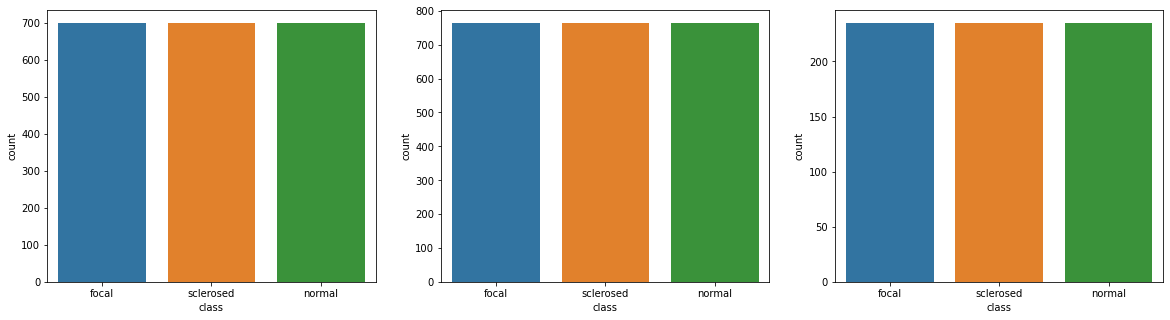

In [6]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli_dataset/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli_dataset/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli_dataset/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli_dataset/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [7]:
BUFFER_SIZE = len(train_folders)

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
IMG_SIZE = 150

In [8]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=BUFFER_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=BUFFER_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              class_mode='categorical', 
                                                              target_size=(IMG_SIZE, IMG_SIZE))

Found 2100 images belonging to 3 classes.
Found 705 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator( rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = test_datagen.flow_from_directory(test_folders,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=BUFFER_SIZE,
                                                   class_mode='categorical',
                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 2290 images belonging to 3 classes.


In [11]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [12]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


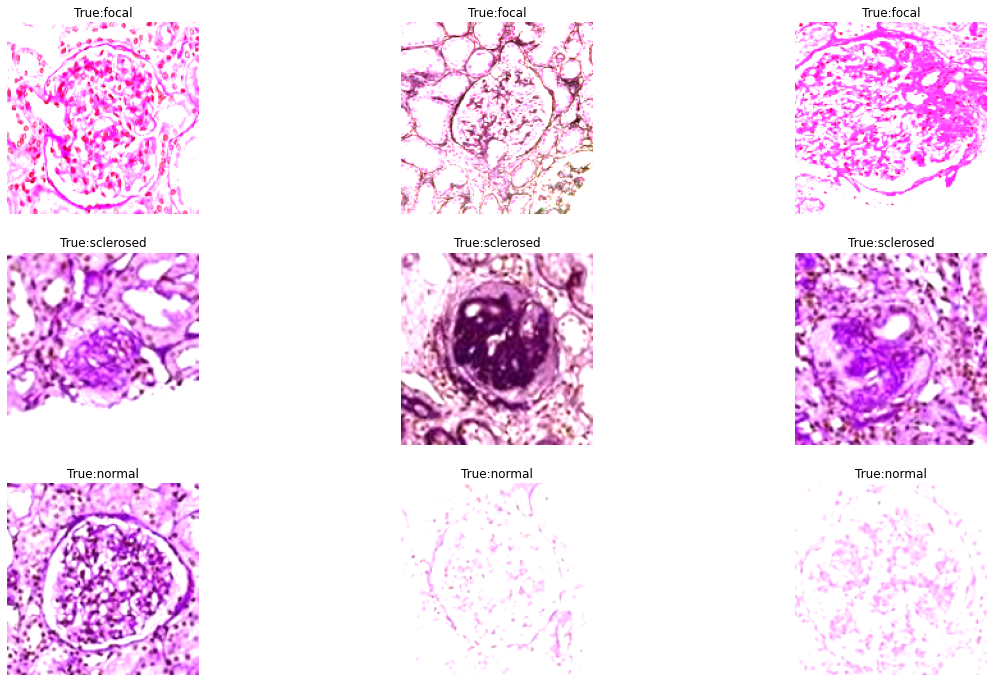

In [13]:
show_few_images(3,None)

In [14]:
#tf.keras.backend.clear_session()

# epoch config
EPOCH = 60

## VGG16

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        

33/33 [==============================] - 6s 176ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.3835 - val_acc: 0.9078
Epoch 26/60
33/33 [==============================] - 6s 176ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.3588 - val_acc: 0.9121
Epoch 27/60
33/33 [==============================] - 6s 187ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.3867 - val_acc: 0.9078
Epoch 28/60
33/33 [==============================] - 6s 179ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.4396 - val_acc: 0.8993
Epoch 29/60
33/33 [==============================] - 6s 174ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.3360 - val_acc: 0.9191
Epoch 30/60
33/33 [==============================] - 6s 179ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.4747 - val_acc: 0.8936
Epoch 31/60
33/33 [==============================] - 6s 178ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.3937 - val_acc: 0.9092
Epoch 32/60
33/33 [==============================] - 6s 182ms/step - loss: 0.0041

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


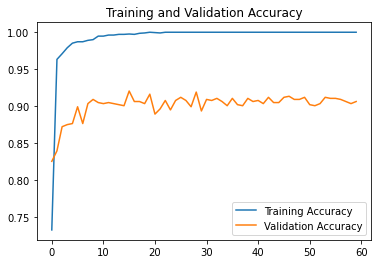

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


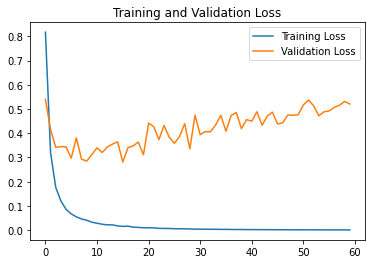

<Figure size 432x288 with 0 Axes>

In [15]:
with strategy.scope():
    vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg16_model.layers:
                layers.trainable=False
    last_output = vgg16_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg16_final_model = Model(vgg16_model.input, vgg_x)
    vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [16]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model

36/36 [==============================] - 59s 2s/step - loss: 3.5823 - acc: 0.4694


## VGG19

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

Epoch 33/60
33/33 [==============================] - 6s 183ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.2051 - val_acc: 0.9333
Epoch 34/60
33/33 [==============================] - 6s 185ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.2512 - val_acc: 0.9220
Epoch 35/60
33/33 [==============================] - 6s 177ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.3087 - val_acc: 0.9106
Epoch 36/60
33/33 [==============================] - 6s 176ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.2812 - val_acc: 0.9163
Epoch 37/60
33/33 [==============================] - 6s 181ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.2942 - val_acc: 0.9135
Epoch 38/60
33/33 [==============================] - 6s 182ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.2248 - val_acc: 0.9333
Epoch 39/60
33/33 [==============================] - 6s 180ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.2901 - val_acc: 0.9149
Epoch 40/60
33/33 [==============================] - 6s 182ms/step - 

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


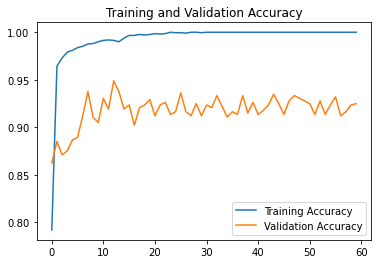

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


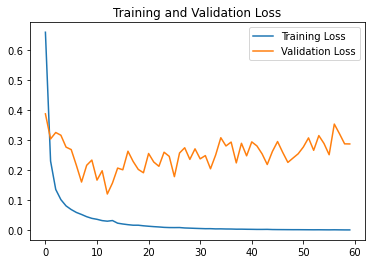

<Figure size 432x288 with 0 Axes>

In [17]:
with strategy.scope():
    vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg19_model.layers:
                layers.trainable=False
    last_output = vgg19_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg19_final_model = Model(vgg19_model.input, vgg_x)
    vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = EPOCH ,validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

In [18]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model

36/36 [==============================] - 8s 225ms/step - loss: 3.5798 - acc: 0.4655


## ResNet101

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 420 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 420 all-reduces with algorithm = nccl, num_packs = 1
33/33 [==============================] - 251s 4s/step - loss: 1.4437 - acc: 0.7973 - val_loss: 7.8153 - val_acc: 0.3333
Epoch 2/60
33/33 [==============================] - 10s 303ms/step - loss: 0.0115 - acc: 0.9966 - val_loss: 8.0514 - val_acc: 0.3333
Epoch 3/60
33/33 [==============================] - 10s 308ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 8.0330 - val_acc: 0.3333
Epoch 4/60
33/33 [==============================] - 10s 311ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 8.5117 - val_acc: 0.3333
Epoch 5/60
33/33 [==============================] - 10s 312ms/step - loss: 4.9504e-04 - acc: 1.0000 - val_loss: 8.7535 - val_acc: 0.3333
Epoch 6/60
33/33 [==============================] - 10s 308ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 9.0996 - val_acc: 0.3333
Epoch 7/60
33/33 [========

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


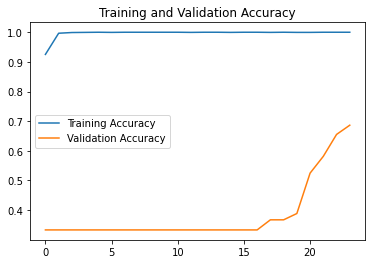

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


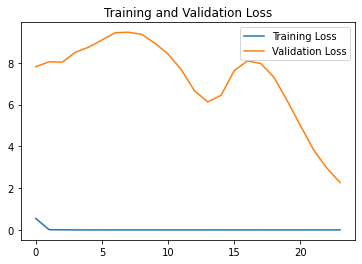

<Figure size 432x288 with 0 Axes>

In [19]:
with strategy.scope():
    ResNet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet101_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet101_x = Flatten()(ResNet101_model.output)
    resnet101_x = Dense(256,activation='relu')(resnet101_x)
    resnet101_x = Dense(3,activation='softmax')(resnet101_x)
    resnet101_x_final_model = Model(inputs=ResNet101_model.input, outputs=resnet101_x)
    resnet101_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet101_x_final_model.summary()
since = time.time()
resnet101_history = resnet101_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101_history, 'resnet101_model')

In [20]:
resnet101_x_final_model.evaluate(test_generator)
resnet101_best_model = resnet101_x_final_model

36/36 [==============================] - 43s 1s/step - loss: 7.7657 - acc: 0.4022


## ResNet101V2

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 346 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 346 all-reduces with algorithm = nccl, num_packs = 1
33/33 [==============================] - 258s 4s/step - loss: 0.6836 - acc: 0.8371 - val_loss: 2.3581 - val_acc: 0.6851
Epoch 2/60
33/33 [==============================] - 10s 287ms/step - loss: 0.0086 - acc: 0.9971 - val_loss: 0.3120 - val_acc: 0.9078
Epoch 3/60
33/33 [==============================] - 10s 286ms/step - loss: 0.0084 - acc: 0.9944 - val_loss: 0.1095 - val_acc: 0.9645
Epoch 4/60
33/33 [==============================] - 10s 292ms/step - loss: 6.7108e-04 - acc: 1.0000 - val_loss: 0.1229 - val_acc: 0.9660
Epoch 5/60
33/33 [==============================] - 10s 291ms/step - loss: 0.0038 - acc: 0.9982 - val_loss: 0.0642 - val_acc: 0.9844
Epoch 6/60
33/33 [==============================] - 10s 293ms/step - loss: 0.0062 - acc: 0.9983 - val_loss: 0.1334 - val_acc: 0.9617
Epoch 7/60
33/33 [========

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


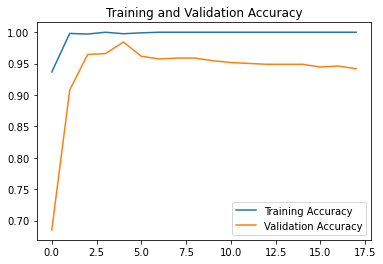

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


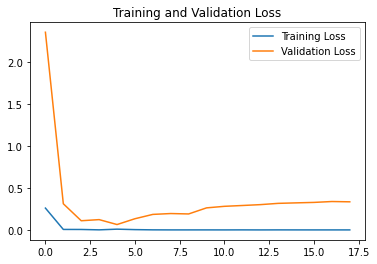

<Figure size 432x288 with 0 Axes>

In [21]:
with strategy.scope():
    ResNet101v2_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    #for layers in ResNet5v2_model.layers:
    #    layers.trainable=False

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet101v2_x = Flatten()(ResNet101v2_model.output)
    resnet101v2_x = Dense(256,activation='relu')(resnet101v2_x)
    resnet101v2_x = Dense(3,activation='softmax')(resnet101v2_x)
    resnet101v2_x_final_model = Model(inputs=ResNet101v2_model.input, outputs=resnet101v2_x)
    resnet101v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet101v2_x_final_model.summary()
since = time.time()
resnet101v2_history = resnet101v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101v2_history, 'resnet101v2_model')

In [22]:
resnet101v2_x_final_model.evaluate(test_generator)
resnet101v2_best_model = resnet101v2_x_final_model

36/36 [==============================] - 45s 1s/step - loss: 3.5994 - acc: 0.4480


## EfficientNetB7

last layer output shape:  (None, 2560)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_____________________________________________________

block5h_dwconv (DepthwiseConv2D (None, 10, 10, 1344) 33600       block5h_expand_activation[0][0]  
__________________________________________________________________________________________________
block5h_bn (BatchNormalization) (None, 10, 10, 1344) 5376        block5h_dwconv[0][0]             
__________________________________________________________________________________________________
block5h_activation (Activation) (None, 10, 10, 1344) 0           block5h_bn[0][0]                 
__________________________________________________________________________________________________
block5h_se_squeeze (GlobalAvera (None, 1344)         0           block5h_activation[0][0]         
__________________________________________________________________________________________________
block5h_se_reshape (Reshape)    (None, 1, 1, 1344)   0           block5h_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5h_se

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
33/33 [==============================] - 279s 5s/step - loss: 0.9862 - acc: 0.6210 - val_loss: 0.2547 - val_acc: 0.9035
Epoch 2/60
33/33 [==============================] - 7s 199ms/step - loss: 0.2366 - acc: 0.9001 - val_loss: 0.2799 - val_acc: 0.8936

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/60
33/33 [==============================] - 6s 188ms/step - loss: 0.1825 - acc: 0.9346 - val_loss: 0.2629 - val_acc: 0.8908

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/60
33/33 [==============================] - 6s 194ms/step - loss: 0.1467 - acc: 0.9447 - val_loss: 0.2547 - val_acc: 0.9035

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 5/60
33/33 [==============================] - 7s 199ms

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


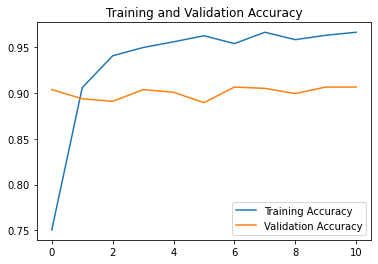

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


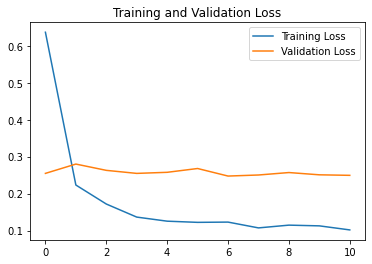

<Figure size 432x288 with 0 Axes>

In [23]:
with strategy.scope():
    effb7_model = EfficientNetB7(pooling='avg', 
                        weights='imagenet', 
                        include_top=False, 
                        input_shape=(150,150,3))
    for layers in effb7_model.layers:
                layers.trainable=False

    last_layer = effb7_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effb7_x = Flatten()(last_output)
    effb7_x = Dense(1024, activation = 'relu')(effb7_x)
    effb7_x = Dropout(0.2)(effb7_x)
    effb7_x = Dense(3, activation = 'softmax')(effb7_x)
    effb7_final_model = Model(effb7_model.input, effb7_x)
    effb7_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFB7
effb7_final_model.summary()

reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [24]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model

36/36 [==============================] - 109s 3s/step - loss: 2.1518 - acc: 0.4786


## EfficientNetL2

last layer output shape:  (None, 5504)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 136)  3672        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 136)  544         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 136)  0           stem_bn[0][0]                    
_____________________________________________________

__________________________________________________________________________________________________
block3j_bn (BatchNormalization) (None, 19, 19, 1056) 4224        block3j_dwconv[0][0]             
__________________________________________________________________________________________________
block3j_activation (Activation) (None, 19, 19, 1056) 0           block3j_bn[0][0]                 
__________________________________________________________________________________________________
block3j_se_squeeze (GlobalAvera (None, 1056)         0           block3j_activation[0][0]         
__________________________________________________________________________________________________
block3j_se_reshape (Reshape)    (None, 1, 1, 1056)   0           block3j_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3j_se_reduce (Conv2D)      (None, 1, 1, 44)     46508       block3j_se_reshape[0][0]         
__________

__________________________________________________________________________________________________
block6h_project_conv (Conv2D)   (None, 5, 5, 824)    4073856     block6h_se_excite[0][0]          
__________________________________________________________________________________________________
block6h_project_bn (BatchNormal (None, 5, 5, 824)    3296        block6h_project_conv[0][0]       
__________________________________________________________________________________________________
block6h_add (Add)               (None, 5, 5, 824)    0           block6h_project_bn[0][0]         
                                                                 block6g_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_conv (Conv2D)    (None, 5, 5, 4944)   4073856     block6h_add[0][0]                
__________________________________________________________________________________________________
block6i_ex

Epoch 1/60
33/33 [==============================] - 347s 6s/step - loss: 17.1458 - acc: 0.3460 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 2/60
33/33 [==============================] - 22s 665ms/step - loss: 1.1001 - acc: 0.3416 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/60
33/33 [==============================] - 23s 685ms/step - loss: 1.0986 - acc: 0.3220 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/60
33/33 [==============================] - 24s 722ms/step - loss: 1.0987 - acc: 0.3241 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/60
33/33 [==============================] - 25s 759ms/step - loss: 1.0986 - acc: 0.3271 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 6/60
33/33 [==============================] - 27s 813ms/step - loss: 1.0986 - acc: 0.34

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


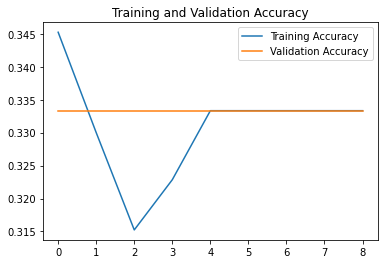

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


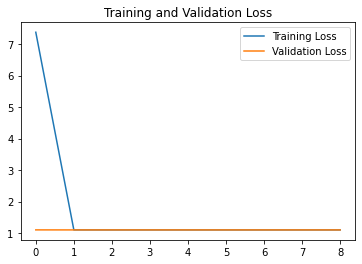

<Figure size 432x288 with 0 Axes>

In [25]:
path_weight = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
with strategy.scope():
    effl2_model = EfficientNetL2(pooling='avg', 
                                 weights=path_weight, 
                                 include_top=False, 
                                 input_shape=(IMG_SIZE,IMG_SIZE,3),
                                 drop_connect_rate=0)
    for layers in effl2_model.layers:
                layers.trainable=False

    last_layer = effl2_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effl2_x = Flatten()(last_output)
    effl2_x = Dense(1024, activation = 'relu')(effl2_x)
    effl2_x = Dropout(0.2)(effl2_x)
    effl2_x = Dense(3, activation = 'softmax')(effl2_x)
    effl2_final_model = Model(effl2_model.input, effl2_x)
    effl2_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFL2
effl2_final_model.summary()

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [26]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model

36/36 [==============================] - 144s 4s/step - loss: 1.0986 - acc: 0.3341


## Combining Similar Model 

In [27]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_vgg_pred = []
combined_resnet_pred = []
combined_effnet_pred = []
vgg16_pred = []
resnet101_pred = []
effnetb7_pred = []
vgg19_pred = []
resnet101v2_pred = []
effnetl2_pred = []
for folder in os.listdir(val_folders):
    
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
        img_normalized = img/IMG_SIZE
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg16_best_model.predict(np.array([img_normalized])))
        vgg16_pred.append(vgg16_image_prediction)
        
        #resnet101
        resnet101_image_prediction = np.argmax(resnet101_best_model.predict(np.array([img_normalized])))
        resnet101_pred.append(resnet101_image_prediction)
        
        #effnetb7
        effnetb7_image_prediction = np.argmax(effb7_best_model.predict(np.array([img_normalized])))
        effnetb7_pred.append(effnetb7_image_prediction)
        
        #vgg19
        vgg19_image_prediction = np.argmax(vgg19_best_model.predict(np.array([img_normalized])))
        vgg19_pred.append(vgg19_image_prediction)
        
        #resnet101v2
        resnet101v2_image_prediction = np.argmax(resnet101v2_best_model.predict(np.array([img_normalized])))
        resnet101v2_pred.append(resnet101v2_image_prediction)
        
        #effnetl2
        effnetl2_image_prediction = np.argmax(effl2_best_model.predict(np.array([img_normalized])))
        effnetl2_pred.append(effnetl2_image_prediction)
        
        #combine_vgg
        image_prediction = mode([vgg19_image_prediction, vgg16_image_prediction])                                  
        combined_vgg_pred.append(image_prediction)
        
        #combine_resnet
        image_prediction = mode([resnet101v2_image_prediction, resnet101_image_prediction])                                  
        combined_resnet_pred.append(image_prediction)
        
        #combine_efficientnet
        image_prediction = mode([effnetb7_image_prediction, effnetl2_image_prediction])                                  
        combined_effnet_pred.append(image_prediction)

## Define Classification

In [28]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

## Result of Classification

Model Accuracy 0.9191489361702128
              precision    recall  f1-score   support

       focal       0.96      1.00      0.98       235
      normal       0.99      0.77      0.86       235
   sclerosed       0.84      0.99      0.91       235

    accuracy                           0.92       705
   macro avg       0.93      0.92      0.92       705
weighted avg       0.93      0.92      0.92       705



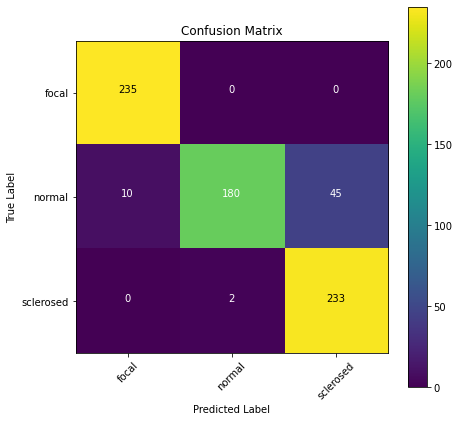

In [29]:
#combined vgg
combined_vgg_pred = [ c[0] for c in combined_vgg_pred]
clf_report(true_value, combined_vgg_pred)

Model Accuracy 0.9460992907801419
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       1.00      0.84      0.91       235
   sclerosed       0.86      1.00      0.93       235

    accuracy                           0.95       705
   macro avg       0.95      0.95      0.95       705
weighted avg       0.95      0.95      0.95       705



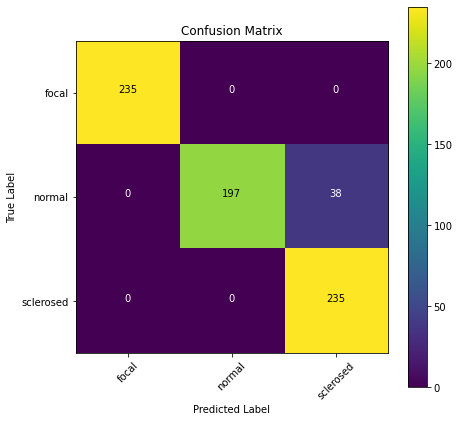

In [30]:
#combined resnet
combined_resnet_pred = [ c[0] for c in combined_resnet_pred]
clf_report(true_value, combined_resnet_pred)

Model Accuracy 0.9134751773049645
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.88      0.86      0.87       235
   sclerosed       0.87      0.88      0.87       235

    accuracy                           0.91       705
   macro avg       0.91      0.91      0.91       705
weighted avg       0.91      0.91      0.91       705



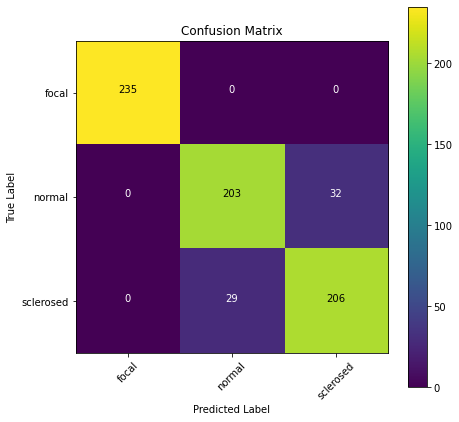

In [31]:
#combined effnet
combined_effnet_pred = [ c[0] for c in combined_effnet_pred]
clf_report(true_value, combined_effnet_pred)

Model Accuracy 0.9106382978723404
              precision    recall  f1-score   support

       focal       0.91      1.00      0.95       235
      normal       1.00      0.73      0.85       235
   sclerosed       0.86      1.00      0.92       235

    accuracy                           0.91       705
   macro avg       0.92      0.91      0.91       705
weighted avg       0.92      0.91      0.91       705



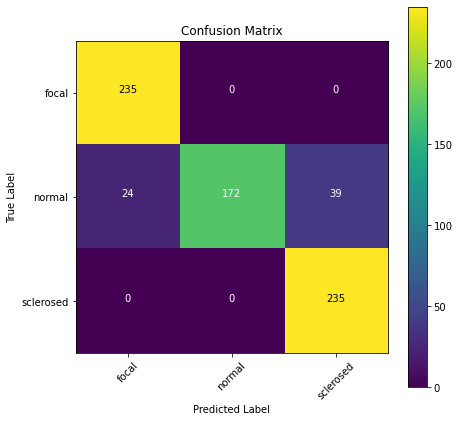

In [32]:
# VGG16 model classification report
clf_report(true_value, vgg16_pred)

Model Accuracy 0.9191489361702128
              precision    recall  f1-score   support

       focal       0.96      1.00      0.98       235
      normal       0.99      0.77      0.86       235
   sclerosed       0.84      0.99      0.91       235

    accuracy                           0.92       705
   macro avg       0.93      0.92      0.92       705
weighted avg       0.93      0.92      0.92       705



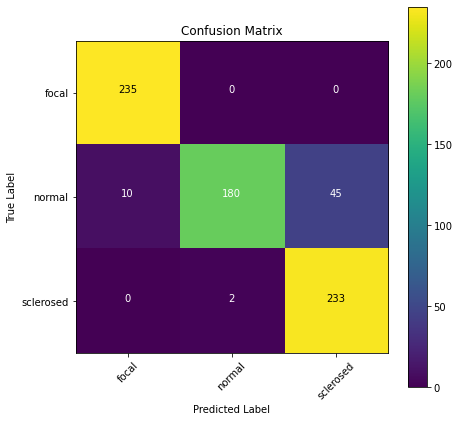

In [33]:
# VGG19 model classification report
clf_report(true_value, vgg19_pred)

Model Accuracy 0.6921985815602837
              precision    recall  f1-score   support

       focal       1.00      0.86      0.92       235
      normal       0.61      0.22      0.32       235
   sclerosed       0.56      1.00      0.72       235

    accuracy                           0.69       705
   macro avg       0.72      0.69      0.65       705
weighted avg       0.72      0.69      0.65       705



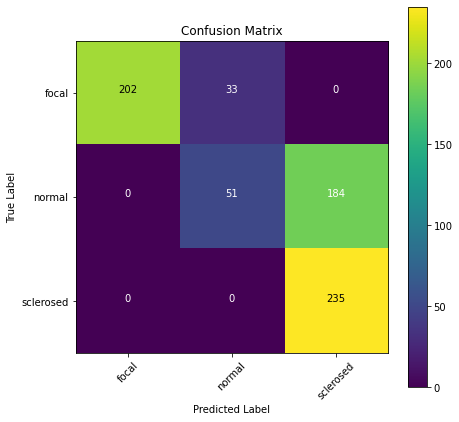

In [34]:
# Resnet50 model classification report
clf_report(true_value, resnet101_pred)

Model Accuracy 0.9460992907801419
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       1.00      0.84      0.91       235
   sclerosed       0.86      1.00      0.93       235

    accuracy                           0.95       705
   macro avg       0.95      0.95      0.95       705
weighted avg       0.95      0.95      0.95       705



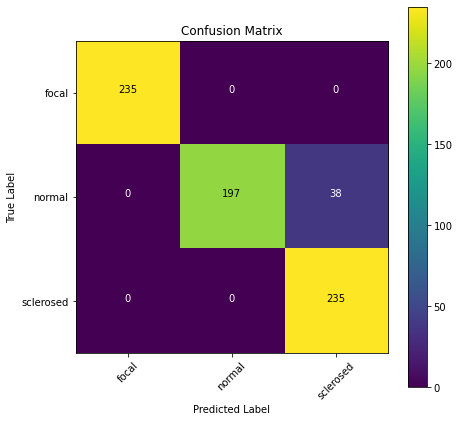

In [35]:
# Resnet50v2 model classification report
clf_report(true_value, resnet101v2_pred)

Model Accuracy 0.9134751773049645
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.88      0.86      0.87       235
   sclerosed       0.87      0.88      0.87       235

    accuracy                           0.91       705
   macro avg       0.91      0.91      0.91       705
weighted avg       0.91      0.91      0.91       705



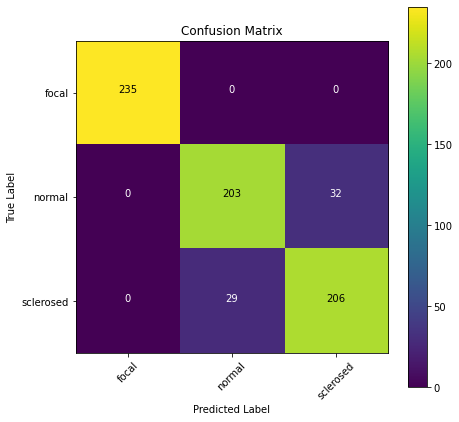

In [36]:
# EfficientNetB7 model classification report
clf_report(true_value, effnetb7_pred)

Model Accuracy 0.3333333333333333
              precision    recall  f1-score   support

       focal       0.33      1.00      0.50       235
      normal       0.00      0.00      0.00       235
   sclerosed       0.00      0.00      0.00       235

    accuracy                           0.33       705
   macro avg       0.11      0.33      0.17       705
weighted avg       0.11      0.33      0.17       705



/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


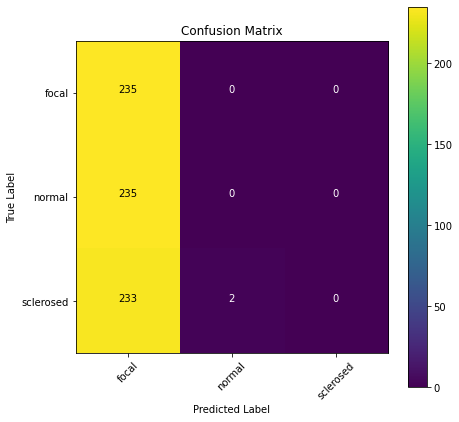

In [37]:
# EfficientNetL2 model classification report
clf_report(true_value, effnetl2_pred)

## Display Prediction Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


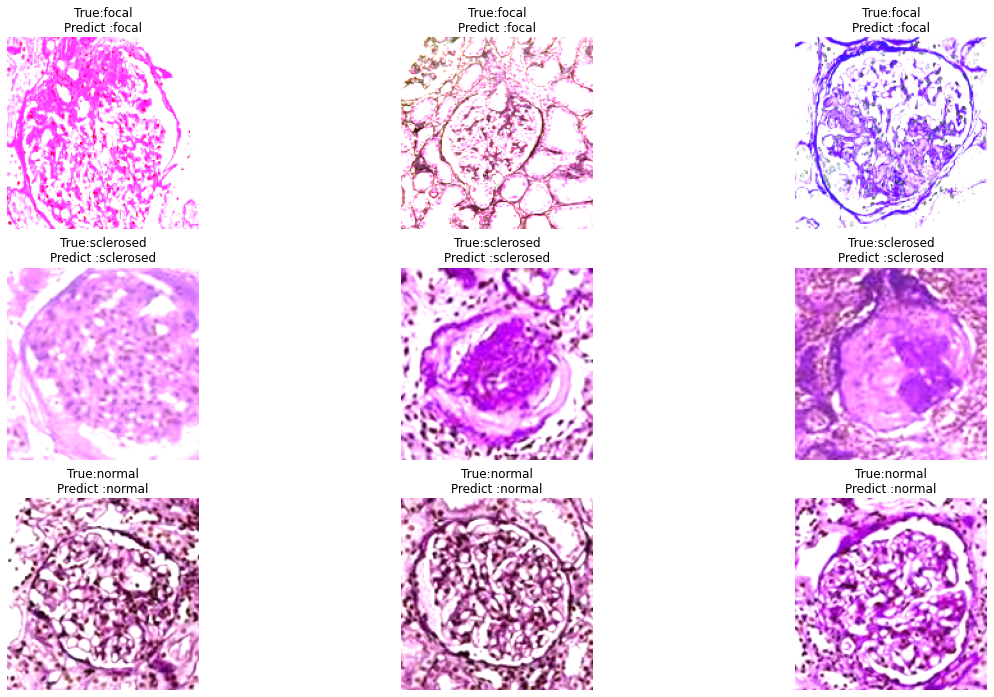

In [38]:
show_few_images(3,vgg16_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


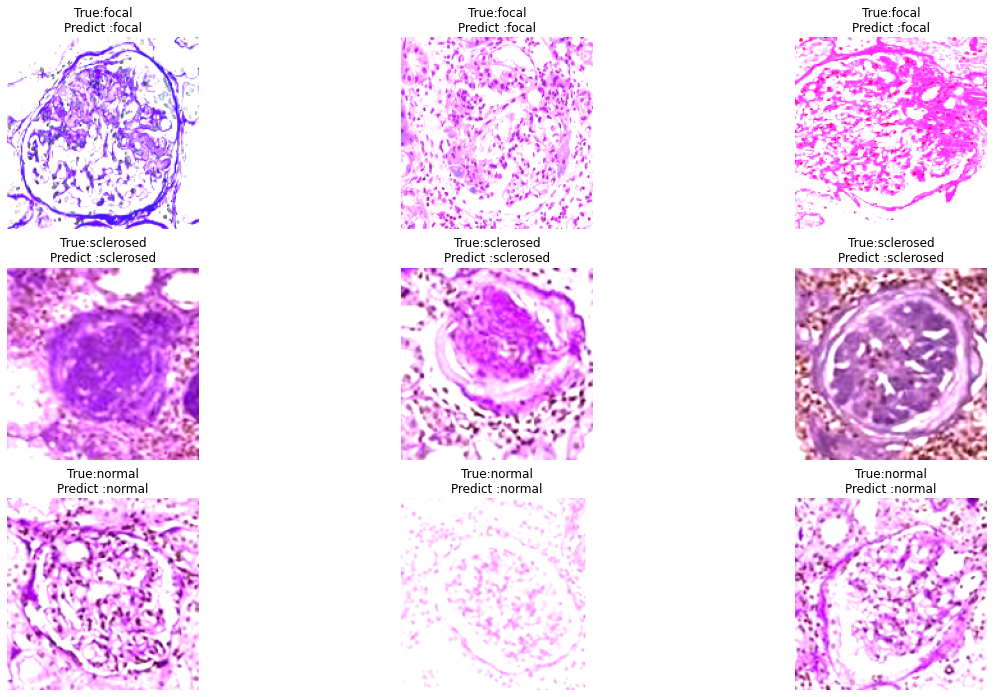

In [39]:
show_few_images(3,vgg19_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


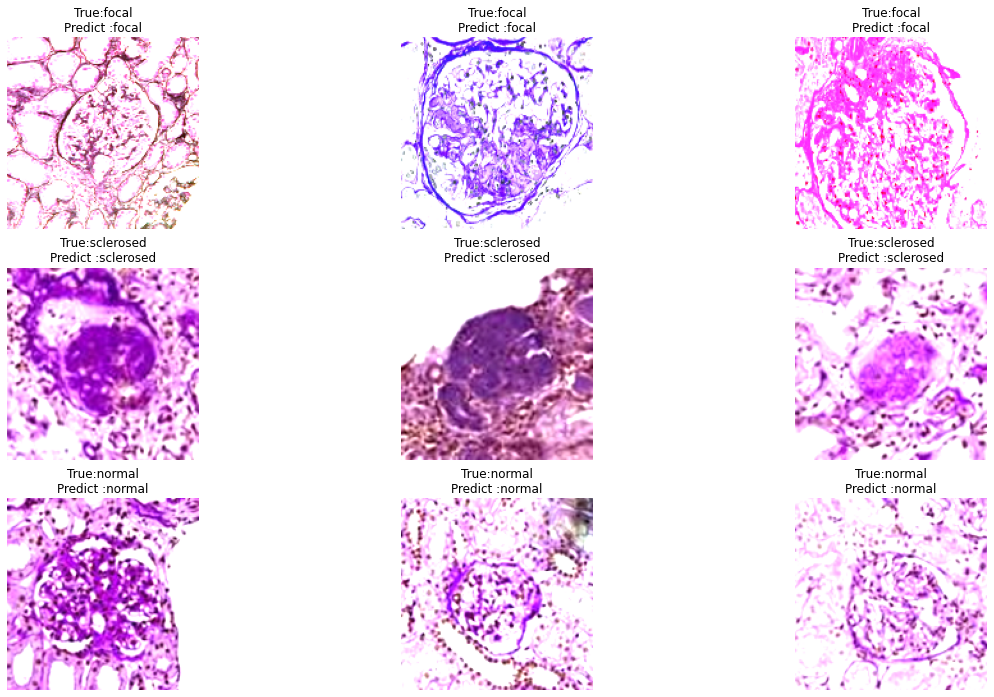

In [40]:
show_few_images(3,resnet101_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


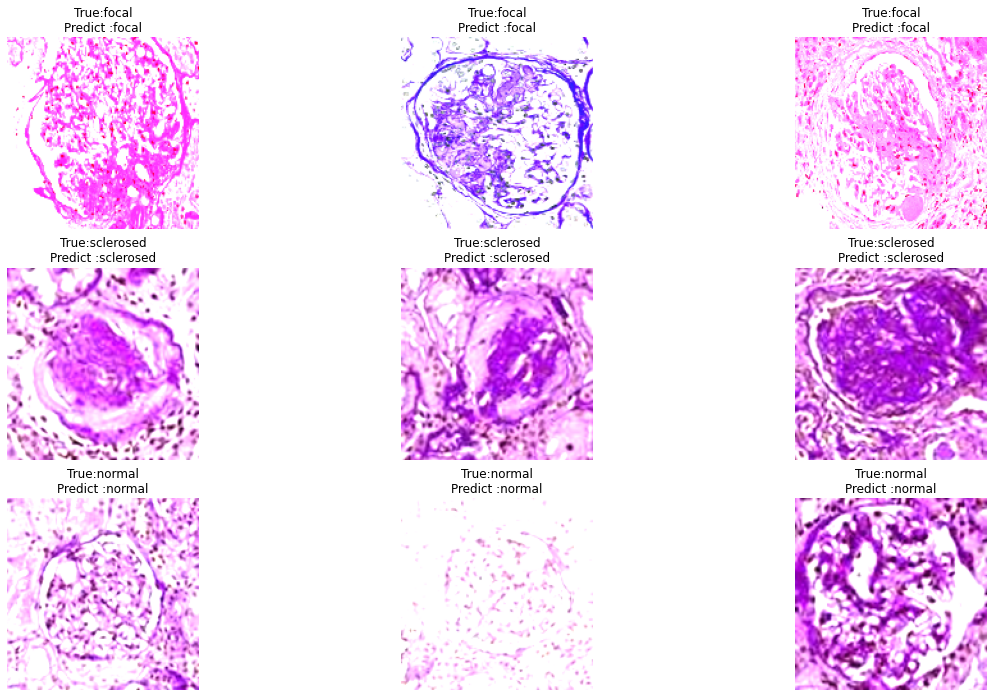

In [41]:
show_few_images(3,resnet101v2_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


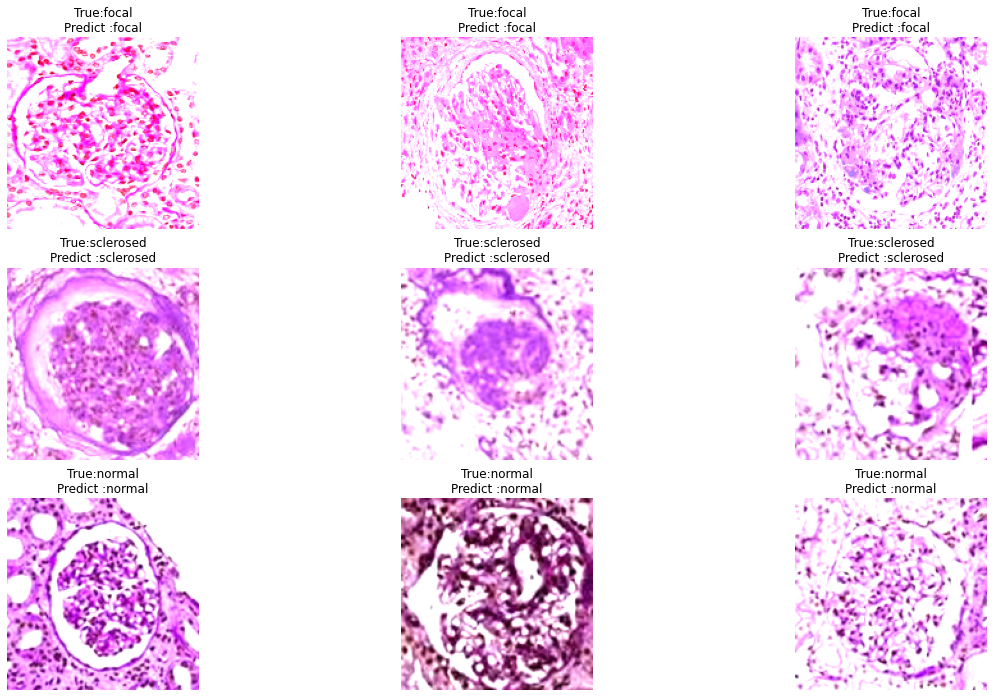

In [42]:
show_few_images(3,effb7_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


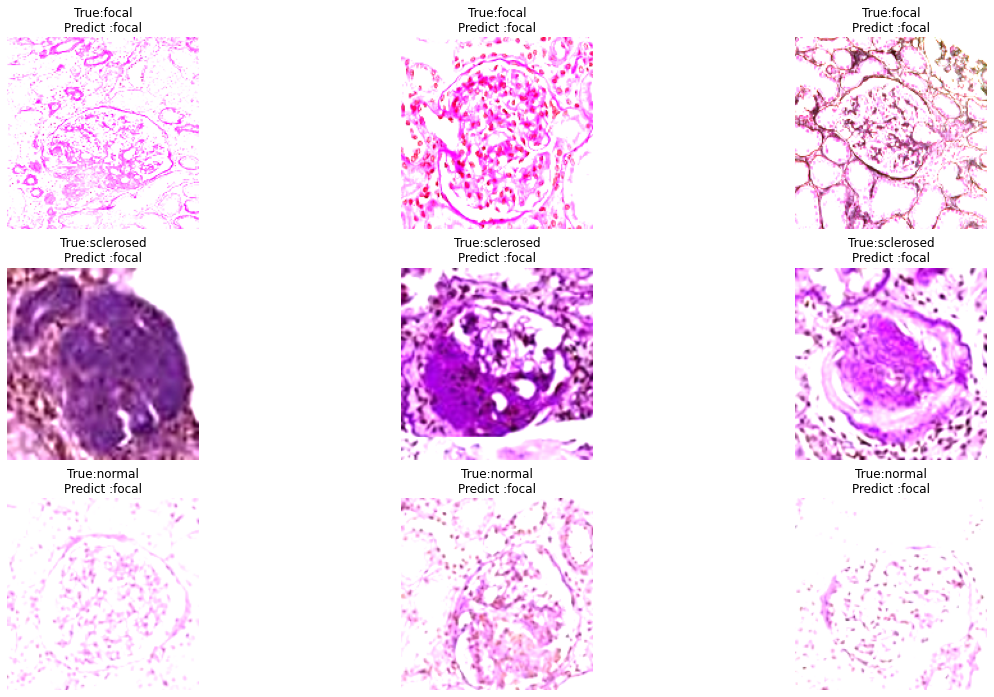

In [43]:
show_few_images(3,effl2_best_model)